In [1]:
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
def find_biggest_contour(image):
    # Copy
    image = image.copy()
    contours, hierarchy = cv2.findContours(image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    # Isolate largest contour
    contour_sizes = [(cv2.contourArea(contour), contour) for contour in contours]
    biggest_contour = max(contour_sizes, key=lambda x: x[0])[1]

    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [biggest_contour], -1, 255, -1)
    return biggest_contour, mask

def scaleRadius(img, scale):
    d = int(img.shape[0]/2)
    x=img[d,:,:].sum(1)
    r=(x>x.mean()/10).sum()/2
    s=scale*1.0/r
    return cv2.resize(img,(0,0),fx=s, fy=s)

In [3]:
INPUT_DIR = '/home/quang/working/image_processing/data/train_1/'
OUTPUT_DIR_CROP = '/home/quang/working/image_processing/data/train_crop_1/'
OUTPUT_DIR_COLOR = '/home/quang/working/image_processing/data/train_color_1/'

# INPUT_DIR = '/home/quang/working/image_processing/data/valid/'
# OUTPUT_DIR_CROP = '/home/quang/working/image_processing/data/valid_crop/'
# OUTPUT_DIR_COLOR = '/home/quang/working/image_processing/data/valid_color/'
list_names_path = glob.glob(INPUT_DIR + '*/*')

In [3]:
# INPUT_DIR = '/home/quang/working/image_processing/data/train_1/'
# OUTPUT_DIR_RESIZED = '/home/quang/working/image_processing/data/train_resize/'

# INPUT_DIR = '/home/quang/working/image_processing/data/valid/'
# OUTPUT_DIR_RESIZED = '/home/quang/working/image_processing/data/valid_resize/'
# list_names_path = glob.glob(INPUT_DIR + '*/*')
# for path_temp in tqdm(list_names_path):
#     clas_temp = path_temp.split('/')[-2]
#     file_temp = path_temp.split('/')[-1]
#     img_org = cv2.imread(path_temp)
#     img_croped = cv2.resize(img_org, (256, 256), interpolation = cv2.INTER_CUBIC)
#     cv2.imwrite(OUTPUT_DIR_RESIZED + clas_temp + '/' + file_temp, img_croped)

100%|██████████| 96/96 [00:04<00:00, 20.38it/s]


In [4]:
for path_temp in tqdm(list_names_path):
    clas_temp = path_temp.split('/')[-2]
    file_temp = path_temp.split('/')[-1]
    img_org = cv2.imread(path_temp)
    img_pad = np.pad(img_org, [(500, ), (500, ), (0, )], mode='constant')

    ratio = 512.0/(img_org.shape[0] + 1000.0)
    img = cv2.resize(img_pad, (0,0), fx=ratio, fy=ratio, interpolation = cv2.INTER_CUBIC)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img.astype(int)
    img_g = img[:,:,1] + 1
    img_th = (img[:,:,2]/(img_g))*np.mean(img, axis=2)
    kernel = np.ones((5,5),np.float32)/25
    img_th_smt = cv2.filter2D(img_th,-1,kernel)
    img_th_smt = np.clip(img_th_smt,0,255)

    img_th_smt_8U = np.array(img_th_smt, dtype = np.uint8)
    ret2,th2 = cv2.threshold(img_th_smt_8U,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    biggest_contour, mask = find_biggest_contour(th2)

    (x, y), radius = cv2.minEnclosingCircle(biggest_contour)
    # convert all values to int
    center = (int(x), int(y))
    radius = int(radius)

    # img_result = np.copy(img_pad)
    x_org = x/ratio 
    y_org = y/ratio
    radius_org = radius/ratio

    crop_img = img_pad[int(y_org-radius_org):int(y_org+radius_org), int(x_org-radius_org):int(x_org+radius_org),:]
    img_croped = cv2.resize(crop_img, (256, 256), interpolation = cv2.INTER_CUBIC)
    cv2.imwrite(OUTPUT_DIR_CROP + clas_temp + '/' + file_temp, img_croped)

    scale =300
    a = img_croped.copy()
    a=scaleRadius(a, scale)
    a=cv2.addWeighted(a,4,cv2.GaussianBlur(a, (0,0), scale/30), -4,128)
    cv2.imwrite(OUTPUT_DIR_COLOR + clas_temp + '/' + file_temp, a)

100%|██████████| 400/400 [00:40<00:00,  9.87it/s]


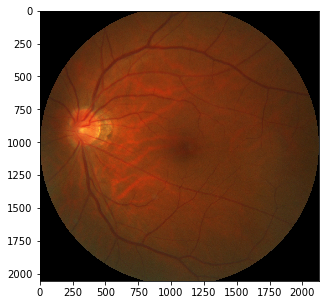

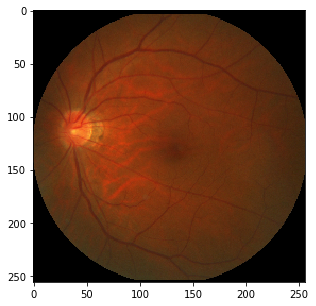

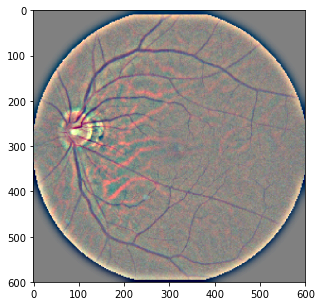

In [5]:
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(img_org,cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(img_croped,cv2.COLOR_BGR2RGB))
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(a,cv2.COLOR_BGR2RGB))
plt.show()